# Ordered Logistic Regression

In [79]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam
import matplotlib.gridspec as gridspec

numpyro.set_host_device_count(4)
az.style.use("arviz-darkgrid")

Some data on how people respond to a questionnaire

0 - not satsified
1 - kinda satisfied
2 - totally satisfied

feature: number of hours that people work

is it regression? no.
is it classification? kinda.

## Generate data

In [2]:
n_samples = 112
hours_worked = stats.norm(35, 3).rvs(size=n_samples)
survey_response_raw = 3 + 1.1 * hours_worked + stats.norm(0, 0.5).rvs(n_samples)
survey_response = np.where(
    survey_response_raw < 37,
    0,
    np.where(survey_response_raw < 42, 1, 2),
)

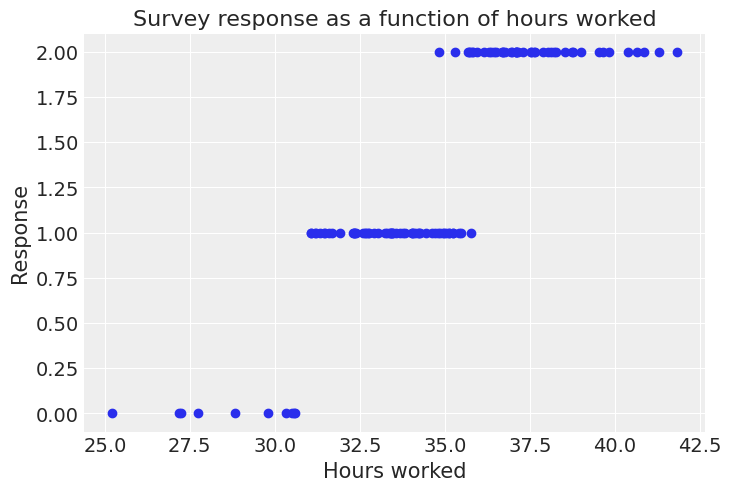

In [96]:
fig, ax = plt.subplots()
ax.plot(hours_worked, survey_response, "o");
ax.set_xlabel('Hours worked')
ax.set_ylabel('Response');
ax.set_title('Survey response as a function of hours worked');

In [4]:
data = pd.DataFrame({"hours_worked": hours_worked, "response": survey_response})

In [5]:
train = data.sample(frac=0.8).copy().reset_index(drop=True)
test = data.loc[~data.index.isin(train.index)].copy().reset_index(drop=True)

train["hours_worked_scaled"] = (
    train["hours_worked"] - train["hours_worked"].mean()
) / train["hours_worked"].std()
test["hours_worked_scaled"] = (
    test["hours_worked"] - train["hours_worked"].mean()
) / train["hours_worked"].std()

In [6]:
train.shape, test.shape

((90, 3), (22, 3))

In [97]:
train

,hours_worked,response,hours_worked_scaled
0,31.443789,1,-1.017584
1,35.459886,1,0.288457
2,34.837592,2,0.086086
3,27.731952,0,-2.224679
4,32.393056,1,-0.708881
...,...,...,...
85,41.817869,2,2.356082
86,37.647285,2,0.999802
87,37.106414,2,0.823910
88,38.024308,2,1.122410


## Categorical Distribution

In [7]:
samples = dist.Categorical(probs=jnp.array([0.2, 0.5, 0.3])).sample(
    jax.random.PRNGKey(3), sample_shape=(30,)
)
samples

DeviceArray([0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2,
             1, 0, 1, 1, 1, 0, 1, 1, 0, 2], dtype=int32)

## Back to our problem

Should be try predicting these probabilities directly?
Maybe not, maybe we need some additional structure to capture the ordering among them.



In [8]:
train["response"].value_counts(normalize=True).sort_index()

0    0.088889
1    0.511111
2    0.400000
Name: response, dtype: float64

In [9]:
train["response"].value_counts(normalize=True).sort_index().cumsum()

0    0.088889
1    0.600000
2    1.000000
Name: response, dtype: float64

```
p_0: probability of survey response 0
p_1: probability of survey response 1
p_2: probability of survey response 2

q_0: probability of survey response 0
q_1: probability of survey response 0 or 1
q_2: probability of survey response 0 or 1 or 2
```

`q_2` is guaranteed to be 1, so we only need to bother predicting `q_0` and `q_1`.

Note that we can easily transform between them:
```
p_0 = q_0
p_1 = q_1 - q_0
p_2 = q_2 - q_1 - q_0 = 1 - q_1 - q_0
```

If we can find `q`, we can derive `p` from it. 
But...how do we predict `q`?

In [10]:
scipy.special.logit(
    train["response"].value_counts(normalize=True).sort_index().cumsum()
)

0   -2.327278
1    0.405465
2         inf
Name: response, dtype: float64

`q` need to be between 0 and 1, which is inconvenient. Can we instead predict a quantity which is unconstrained, and then transform it so it's between 0 and 1?

Reminder:

    logit(p) := log(p/(1-p))
   
So, let's predict:

    logits = logit(q)
    
These logits are gonna be somewhere along the real number line, and the effect will be:

    logits_0: log odds of survey response 0
    logits_1: log odds of survey response 0 or 1
    
So, how to predict these `logits`? We have a feature (`hours_worked`), so let's use it!

    prediction = intercept + coefficient * hours_worked
    
    logits_0 = cutpoint_0 - prediction
    logits_1 = cutpoint_1 - prediction

In [11]:
def ordered_logistic_regression(hours_worked_scaled, n_responses, response=None):

    intercept = numpyro.sample(
        "intercept",
        dist.Normal(0, 1),
    )
    coefficient = numpyro.sample(
        "coefficient",
        dist.Normal(0, 0.5),
    )

    prediction = intercept + coefficient * hours_worked_scaled
    cutpoints = numpyro.sample("cutpoints", dist.Normal(0, 1).expand([n_responses - 1]))

    probs = numpyro.deterministic(
        "probs",
        jnp.diff(
            jnp.pad(
                jax.scipy.special.expit(cutpoints - prediction[:, jnp.newaxis]),
                pad_width=((0, 0), (1, 1)),
                constant_values=(0, 1),
            )
        ),
    )

    numpyro.sample(
        "obs",
        dist.Categorical(probs=probs),
        obs=response,
    )

In [12]:
prior_pred = numpyro.infer.Predictive(ordered_logistic_regression, num_samples=100)
prior_predictions = prior_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=train["hours_worked_scaled"].to_numpy(),
    n_responses=3,
)

Text(0, 0.5, 'Probability of response 0')

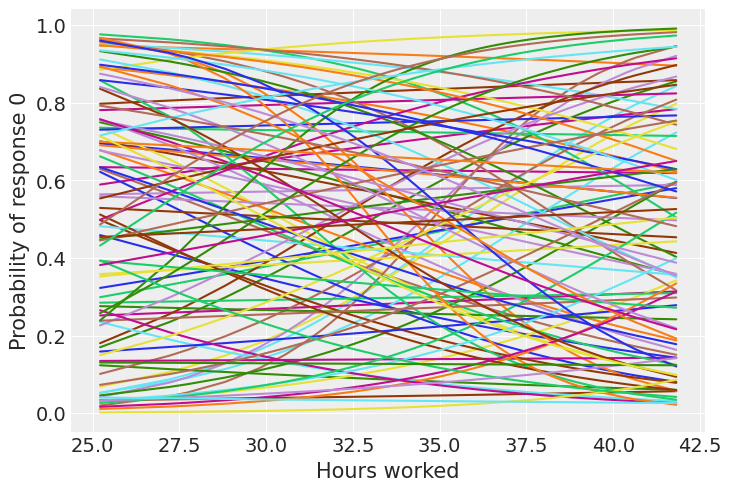

In [25]:
fig, ax = plt.subplots()
idx = train["hours_worked"].sort_values().index
ax.plot(
    train.loc[idx, "hours_worked"], prior_predictions["probs"][:, idx.to_numpy(), 0].T
)
ax.set_xlabel("Hours worked")
ax.set_ylabel("Probability of response 0")

In [14]:
sampler = numpyro.infer.NUTS(ordered_logistic_regression)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(93),
    hours_worked_scaled=train["hours_worked_scaled"].to_numpy(),
    n_responses=3,
    response=train["response"].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  coefficient      2.18      0.29      2.18      1.68      2.64   1877.47      1.00
 cutpoints[0]     -2.51      0.65     -2.51     -3.55     -1.42   1530.19      1.00
 cutpoints[1]      1.62      0.61      1.61      0.66      2.67   1494.62      1.00
    intercept      0.93      0.60      0.93     -0.02      1.90   1476.71      1.00

Number of divergences: 0


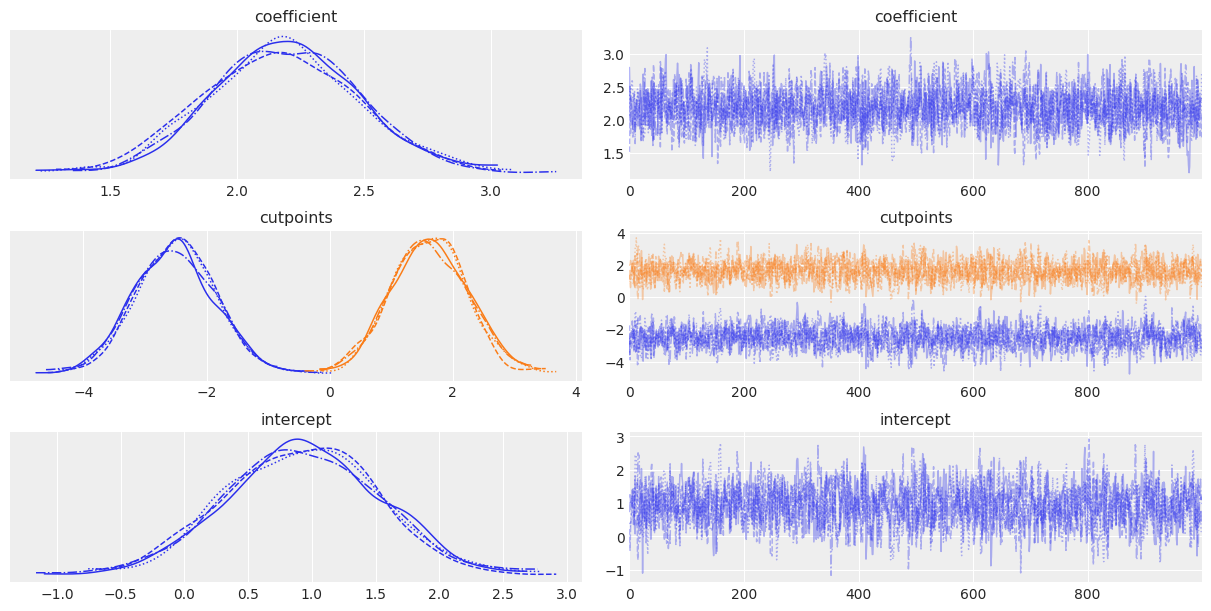

In [16]:
az.plot_trace(az.from_numpyro(mcmc), var_names=["~probs"]);

In [26]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=train["hours_worked_scaled"].to_numpy(),
    n_responses=3,
)

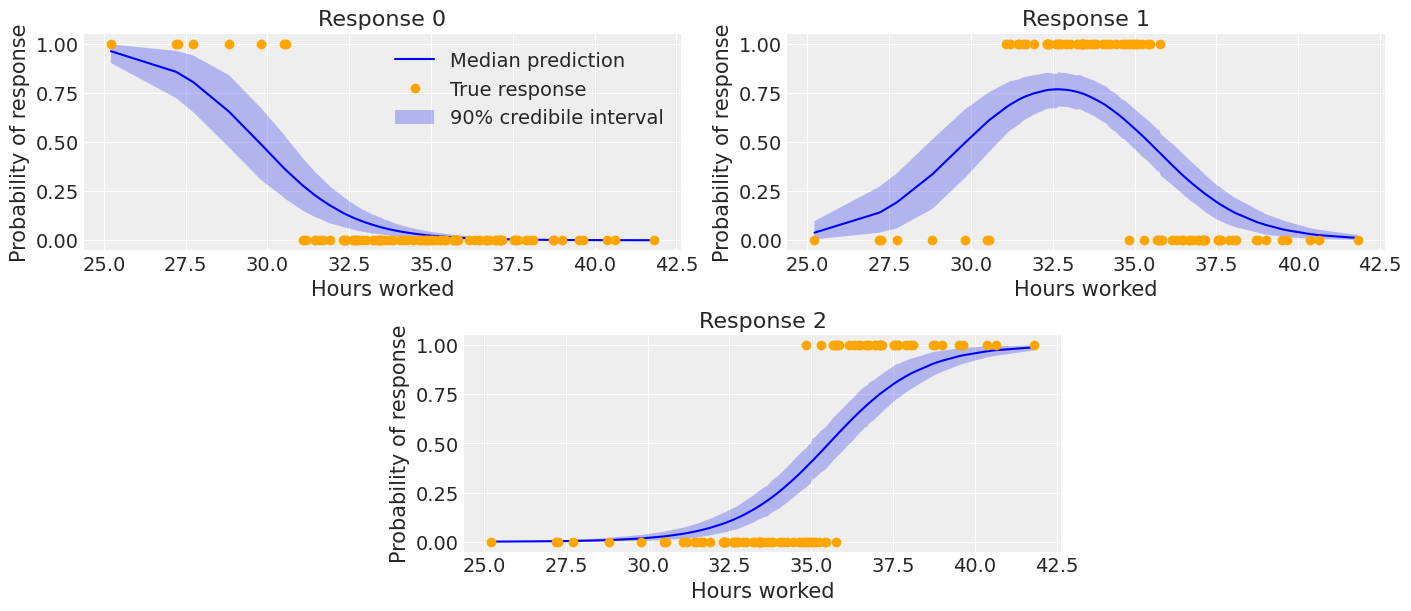

In [78]:
fig = plt.figure(figsize=(14, 6))
idx = train["hours_worked"].sort_values().index

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in (0, 1, 2):
    ax[response].fill_between(
        train.loc[idx, "hours_worked"],
        *numpyro.diagnostics.hpdi(post_predictions["probs"][:, idx.to_numpy(), response]),
        alpha=.3,
        label="90% credibile interval"
    )
    ax[response].plot(
        train.loc[idx, "hours_worked"],
        jnp.median(post_predictions["probs"][:, idx.to_numpy(), response], axis=0),
        color="blue",
        label="Median prediction",
    )
    true =  pd.concat(
        [pd.get_dummies(train["response"], prefix="response"), train["hours_worked"]],
        axis=1,
    ).loc[idx]#.plot.scatter(x="hours_worked", y=f"response_{response}", ax=ax[response], c='orange', label=f'True response of {response}')
    ax[response].plot(train.loc[idx, 'hours_worked'], true[f'response_{response}'], 'o', c='orange', label=f'True response')
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    if response == 0:
        ax[response].legend();
    ax[response].set_title(f'Response {response}')

## But wait!

I said at the start that we had a test set. Let's check our predictions on it.

In [89]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=test["hours_worked_scaled"].to_numpy(),
    n_responses=3,
)

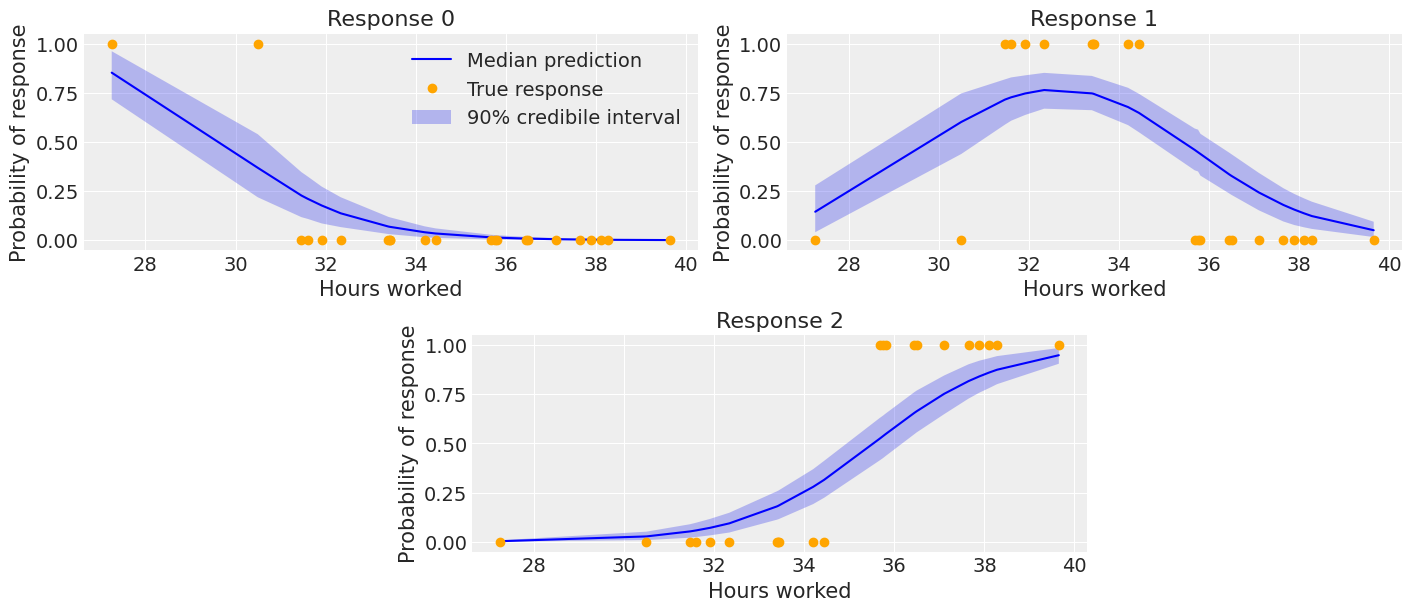

In [90]:
fig = plt.figure(figsize=(14, 6))
idx = test["hours_worked"].sort_values().index

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in (0, 1, 2):
    ax[response].fill_between(
        test.loc[idx, "hours_worked"],
        *numpyro.diagnostics.hpdi(post_predictions["probs"][:, idx.to_numpy(), response]),
        alpha=.3,
        label="90% credibile interval"
    )
    ax[response].plot(
        test.loc[idx, "hours_worked"],
        jnp.median(post_predictions["probs"][:, idx.to_numpy(), response], axis=0),
        color="blue",
        label="Median prediction",
    )
    true =  pd.concat(
        [pd.get_dummies(test["response"], prefix="response"), test["hours_worked"]],
        axis=1,
    ).loc[idx]
    ax[response].plot(test.loc[idx, 'hours_worked'], true[f'response_{response}'], 'o', c='orange', label=f'True response')
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    if response == 0:
        ax[response].legend();
    ax[response].set_title(f'Response {response}')

## Resources

Statistical Rethinking, by Richard McElreath (life-changing book)

Betancourt's case studies